# Tutorial ABM virtual environment

First step is to install the library, you just need to go the folder of the forked / cloned repo (i.e. inside `your_path/rl_opts/`) and run (see more in the Readme of the library)

`
pip install -e .
`


Now we can import the virtual environment + other libraries we will need later:

In [ ]:
from rl_opts.virtual_abm import virtual_ABM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

Here is the documentation of this class:

In [ ]:
from nbdev import show_doc
show_doc(virtual_ABM)

---

[source](https://github.com/gorkamunoz/rl_opts/blob/master/rl_opts/virtual_abm.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### virtual_ABM

>      virtual_ABM (num_episodes:int=None, time_ep:int=None, L:float=5,
>                   r:float=1, max_counter:int=500, gamma_damping:float=0.001,
>                   eta_glow_damping:float=0.001, max_no_H_update:int=10000)

*Initialize self.  See help(type(self)) for accurate signature.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| num_episodes | int | None | If int, number of episodes. If None, don't consider episodes |
| time_ep | int | None | If int, length of an episodes. If episodes = None, it is not considered. |
| L | float | 5 | Size of the environment |
| r | float | 1 | Radius of the target |
| max_counter | int | 500 | Maximum number for the agent's phase counter (i.e. what it gets as station) |
| gamma_damping | float | 0.001 | Gamma of PS |
| eta_glow_damping | float | 0.001 | Glow of PS |
| max_no_H_update | int | 10000 | maximum number of steps before an update of H and G matrices. |

# Testing on ABM

To showcase its working we will import a function that generates displacements via Active Brownian motion:

In [ ]:
from rl_opts.virtual_abm import get_ABM_motion

Let's set some parameters, change them at will!

In [ ]:
D = 2 # Diffusion coefficient (mum² s⁻¹)
L = 100 # Size of the box (mu) 
tau = L**2 / (4*D) #  Typical time required by a passive particle to cover this distance (s)

Pe = 100 # Péclet number
v = Pe * L / tau  # self-propulsion velocity
dt = 1e-4*tau # Integration time
vdt = v*dt 
ell = 1 # Dimensionless persistence length
D_theta = v/ell  # Rotational diffusion coefficient

sigma = np.sqrt(2*D*dt); # sigma for translational
sigma_theta = np.sqrt(2*D_theta*dt) # sigma for rotational

r = 2 # Size of the target

And now let's define our virtual wrapper. This wrapper will take care of everything, from the update of the virtual environment (i.e. moving the particle and checking when we find the target) as well as the training the agent. Let's see how that works:

In [ ]:
wrap = virtual_ABM(L = L, r = r) 

Note that declaring the agent takes a bit because we are using `numba`, which compiles parts of the code in the first run to make subsequent runs much faster. Now, this wrap has only **one** important function: `wrap.step`. This gets as input the displacement you measure in the experiment and outputs the next action. We only have two actions:

- 0: continue in the current phase (active or passive)
- 1: change phase

In [ ]:
displacement = (0.4, 0.5) # x and y measured displacement

wrap.step(displacement)

1

Again, the first run may take a bit longer. Now let's check how this works in a bigger scenario. To get something that resembles more a RL scenario, let's define the same wrapper but with some number of episodes and episode lengths. The wrapper will take care of keeping track of all this.

In [ ]:
wrap = virtual_ABM(L = L, r = r,
                   num_episodes = 50,
                   time_ep = 100,
                   gamma_damping = 0.01, # This is the learning parameter gamma from PS
                   eta_glow_damping = 0.001 # This is the learning parameter eta from PS
                  ) 
# I manually change the policy of the agent to have longer passive phases:
wrap.agent.h_matrix[0, 1::2] *= 10

We can now do a loop in which we get the displacements from the previous ABM functions. We will loop till we reach the max number of episodes

In [ ]:
# We first initialize the environmnet. This initializes the epoch counter, sets the
# the particle and agent in random positions and resents resetting some of the learning parameters
wrap.init_training()

# Initial phase of the agent. Note that the agent always starts in the passive phase. 
phi =  wrap.current_phase
# If you want to start in the active phase, you just need to set:
wrap.current_phase = 1
# at the start of the code.


# We set a random initial direction for the ABM generator
theta = 2*np.pi*np.random.rand() 

# Let's save the position of the agent and targets at each time step and each episode, as well as its phase and rewards 
particle_pos = np.zeros((wrap.num_episodes, wrap.time_ep, 2))
target_pos = np.zeros((wrap.num_episodes, wrap.time_ep, 2))
phases = np.zeros((wrap.num_episodes, wrap.time_ep))
rewards = np.zeros((wrap.num_episodes, wrap.time_ep))


while wrap.epoch < wrap.num_episodes:

    # Saving stuff
    particle_pos[wrap.epoch, wrap.t_ep] = wrap.env.positions[0]
    target_pos[wrap.epoch, wrap.t_ep] = wrap.env.target_positions[0]
    phases[wrap.epoch, wrap.t_ep] = wrap.current_phase

    # Generating displacement via ABM
    x0, y0 = wrap.env.positions[0].copy()
    x1, y1, theta = get_ABM_motion(x0, y0, theta, phi, vdt, sigma, sigma_theta, L)

    # Now we send this to the wrapper. The step function can also give you the reward if asked:
    displacement = (x1-x0, y1-y0)
    action, reward = wrap.step(displacement, return_reward=True)

    # Update the phase for the ABM generator. This should be the input in the experiment to change phase too.
    if action == 1:
        phi = 1 - phi

    # And let's save the rewards (nothing different than zero to be expected here)
    rewards[wrap.epoch-1, wrap.t_ep-1] = reward # minus ones are needed here because wrap.step already updated the epoch and t_ep

Let's plot the movement of the agent in few episode, together with the position of the target:

[Text(0, 0.5, '$L = 100 \\ \\mu m$')]

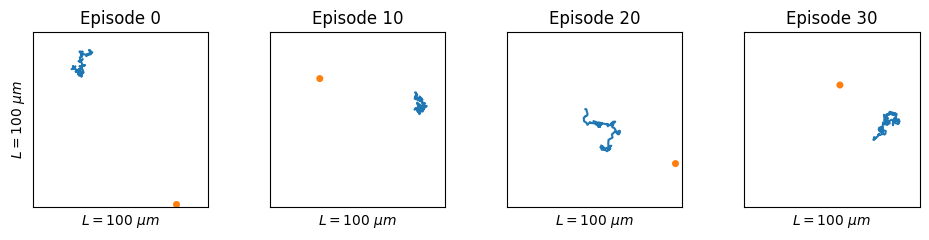

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (4*2.5, 2.5), tight_layout = True)

episodes_vis = [0, 10, 20, 30] # The episodes we will visualize

for ax, ep in zip(axs, episodes_vis):
    ax.plot(particle_pos[ep,:,0], particle_pos[ep,:,1])
    
    # Visualizing the target. Note that here I considered that there were not encounters,
    # so there was no relocation of the target withing an episode. This won't be true when
    # we do proper trainings
    circle = patches.Circle((target_pos[ep,0,0],target_pos[ep,0,1]), radius=r, facecolor='C1')
    ax.add_patch(circle)
    
    ax.set_title(f'Episode {ep}')
    
plt.setp(axs, xlim = (0, L), ylim = (0, L), xticks = [], yticks = [], xlabel = fr'$L = {L} \ \mu m$', aspect = 'equal');
plt.setp(axs[0], ylabel = fr'$L = {L} \ \mu m$')

We can also take a look at the phases of the agent during some of the epochs:

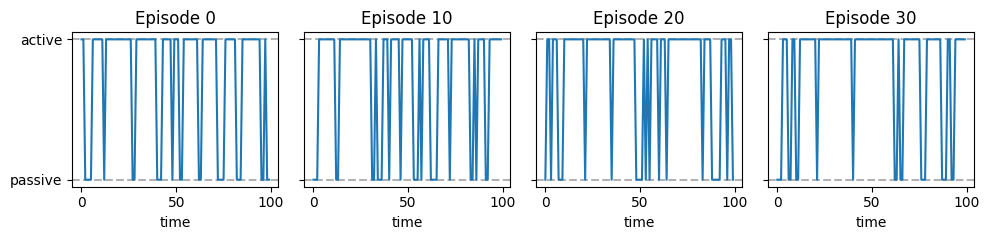

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (4*2.5, 2.5), tight_layout = True)
episodes_vis = [0, 10, 20, 30] # The episodes we will visualize

for ax, ep in zip(axs, episodes_vis):    
    ax.plot(np.arange(wrap.time_ep), phases[ep, :], zorder = 10)
    ax.set_title(f'Episode {ep}')

    ax.axhline(0, c = 'k', ls = '--', alpha = 0.3)
    ax.axhline(1, c = 'k', ls = '--', alpha = 0.3)
    
plt.setp(axs, xlabel = 'time', yticks = [0,1], yticklabels = []);
plt.setp(axs[0], yticklabels = ['passive', 'active']);

# Runtimes tests

Let's check the runtime of the `wrap.step` function. We create a very efficient training for sparse reward functions, i.e. when very few rewards are given. This is an example of runtime when no reward is given (for that I set a very small `r` so that its almost impossible for the target to land on the target).

In [ ]:
wrap = virtual_ABM(L = 1000, r = 0.00001,
                   num_episodes = 50,
                   time_ep = 100,
                   gamma_damping = 0.01, # This is the learning parameter gamma from PS
                   eta_glow_damping = 0.001 # This is the learning parameter eta from PS
                  ) 

# Run step functions once to compile
wrap.step((0.5, 0.5));

In [ ]:
%timeit wrap.step((0.5, 0.5), return_reward = True)

5.13 µs ± 3.27 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


However, our agents may be very very good and get many rewards. To check runtime here, I created a function which sets a case in which we always get reward and hence update the policy of the agent.

In [ ]:
wrap = virtual_ABM(L = 10, r = 0.01,
                   num_episodes = 50,
                   time_ep = 100,
                   gamma_damping = 0.01, # This is the learning parameter gamma from PS
                   eta_glow_damping = 0.001 # This is the learning parameter eta from PS
                  ) 

def step_with_reward():
    wrap.env.positions = wrap.env.target_positions.copy()
    wrap.current_phase = 0
    wrap.step((0.5, 0.5), return_reward=True)
    

In [ ]:
%timeit step_with_reward()

19.7 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
